In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=3, height=3, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
#         self.reward=(1/self.tmp)**2
        self.reward=(1/self.tmp)**0.5

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=1e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.66
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2000
Best mean reward: 0.66 - Last mean reward per episode: 0.67
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 3000
Best mean reward: 0.67 - Last mean reward per episode: 0.71
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 4000
Best mean reward: 0.71 - Last mean reward per episode: 0.71
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 5000
Best mean reward: 0.71 - Last mean reward per episode: 0.72
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 6000
Best mean reward: 0.72 - Last mean reward per episode: 0.75
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 7000
Best mean reward: 0.75 - Last mean reward per episode: 0.80
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 8000
Best mean reward: 0.80 - Last mean reward per episode: 0.77
Num timest

Num timesteps: 77000
Best mean reward: 1.27 - Last mean reward per episode: 1.27
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 78000
Best mean reward: 1.27 - Last mean reward per episode: 1.28
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 79000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 80000
Best mean reward: 1.28 - Last mean reward per episode: 1.27
Num timesteps: 81000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 82000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 83000
Best mean reward: 1.28 - Last mean reward per episode: 1.27
Num timesteps: 84000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 85000
Best mean reward: 1.28 - Last mean reward per episode: 1.27
Num timesteps: 86000


Num timesteps: 170000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 171000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 172000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 173000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 174000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 175000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 176000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 177000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 178000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 179000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 180000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 181000
Best mean reward: 1.28 - L

Num timesteps: 270000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 271000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 272000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 273000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 274000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 275000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 276000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 277000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 278000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 279000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 280000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 281000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 2

Num timesteps: 370000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 371000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 372000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 373000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 374000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 375000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 376000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 377000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 378000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 379000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 380000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 381000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 3

Num timesteps: 470000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 471000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 472000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 473000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 474000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 475000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 476000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 477000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 478000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 479000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 480000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 481000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 4

Num timesteps: 570000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 571000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 572000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 573000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 574000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 575000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 576000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 577000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 578000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 579000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 580000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 581000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 5

Num timesteps: 670000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 671000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 672000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 673000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 674000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 675000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 676000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 677000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 678000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 679000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 680000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 681000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 6

Num timesteps: 770000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 771000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 772000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 773000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 774000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 775000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 776000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 777000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 778000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 779000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 780000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 781000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 7

Num timesteps: 870000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 871000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 872000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 873000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 874000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 875000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 876000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 877000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 878000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 879000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 880000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 881000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 8

Num timesteps: 970000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 971000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 972000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 973000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 974000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 975000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 976000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 977000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 978000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 979000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 980000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 981000
Best mean reward: 1.28 - Last mean reward per episode: 1.28
Num timesteps: 9

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 17.077737482388816 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
    print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

430642.64376348915 0.11120000000000002
1022.6996450989005 0.22230000000000003
250.80665175950026 0.33340000000000003
89.13287305739055 0.44450000000000006
48.41457378705511 0.5556
25.802009543052513 0.6667000000000001
25.802009543052513 0.6667000000000001
25.802009543052513 0.6667000000000001
25.802009543052513 0.6667000000000001
25.802009543052513 0.6667000000000001


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tmp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tmp` for environment variables or `env.get_wrapper_attr('tmp')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.const to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.const` for environment variables or `env.get_wrapper_attr('const')` that will search the reminding wrappers.
  logger.warn(


In [23]:
print(i)

9



Final Cantilever beam design:


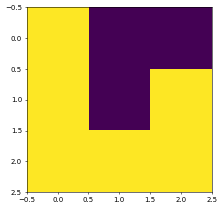

In [24]:
env.render()

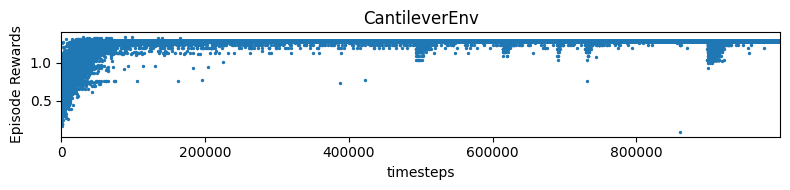

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    print(env.tmp, env.const)
    if dones:
        break
    i+=1

123397.05263641651 0.11120000000000002
12523.995844186962 0.22230000000000003
2613.6377897702464 0.33340000000000003
1506.3708519447355 0.44450000000000006
1336.7112000049435 0.5556
102.19145189644028 0.6667000000000001
102.19145189644028 0.6667000000000001
102.19145189644028 0.6667000000000001
102.19145189644028 0.6667000000000001
102.19145189644028 0.6667000000000001


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tmp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tmp` for environment variables or `env.get_wrapper_attr('tmp')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.const to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.const` for environment variables or `env.get_wrapper_attr('const')` that will search the reminding wrappers.
  logger.warn(


In [29]:
i

9


Final Cantilever beam design:


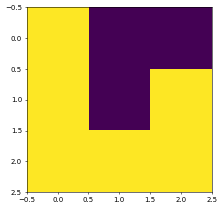

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 

In [32]:
import random


In [33]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<16*0.68753125:
        action = random.randint(0, 15)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rd to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rd` for environment variables or `env.get_wrapper_attr('rd')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for

KeyError: 13

In [34]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<9*0.68753125:
        action = random.randint(0, 8)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)   

105.511125941139 0.5556
30.3800279899591 0.6667000000000001
101.63685263948014 0.5556000000000001
65.15550328024526 0.5556
102.19145189644028 0.6667000000000001
1898.8087795055956 0.44449999999999995
48.61820751792893 0.6667000000000001
32.046386076528044 0.6667000000000001
158.34512923664937 0.5556
33.286684832825735 0.6667
